In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytagi import Normalizer
import pytagi.metric as metric
from pytagi import Normalizer as normalizer
from canari import (
    DataProcess,
    Model,
    plot_data,
    plot_prediction,
    plot_skf_states,
    plot_states,
)
from canari.component import LocalTrend, LocalAcceleration, LstmNetwork, WhiteNoise
from matplotlib.ticker import MultipleLocator
from matplotlib.dates import DayLocator, DateFormatter, HourLocator

from pathlib import Path
project_root = Path.cwd().resolve().parents[0]
data_file = str(project_root / "data/toy_time_series/sine.csv")
data_file_time = str(project_root / "data/toy_time_series/sine_datetime.csv")

In [2]:
df_raw = pd.read_csv(data_file, skiprows=1, delimiter=",", header=None)
time_series = pd.read_csv(data_file_time, skiprows=1, delimiter=",", header=None)
time_series = pd.to_datetime(time_series[0])
df_raw.index = time_series
df_raw.index.name = "date_time"
df_raw.columns = ["values"]

# Add synthetic anomaly to data
trend = np.linspace(0, 0, num=len(df_raw))
time_anomaly = 120
new_trend = np.linspace(0, 1, num=len(df_raw) - time_anomaly)
trend[time_anomaly:] = trend[time_anomaly:] + new_trend
df_raw = df_raw.add(trend, axis=0)

# Data pre-processing
output_col = [0]
data_processor = DataProcess(
    data=df_raw,
    time_covariates=["hour_of_day"],
    train_split=0.4,
    validation_split=0.1,
    output_col=output_col,
)
train_data, validation_data, test_data, all_data = data_processor.get_splits()

In [3]:
######### Define model with parameters #########
seed = 1
def model_with_parameters(param, train_data, validation_data):
    model = Model(
        LocalTrend(),
        LstmNetwork(
            look_back_len=int(param["look_back_len"]),
            num_features=2,
            num_layer=1,
            infer_len=24 * 3,
            num_hidden_unit=50,
            manual_seed=seed,
            smoother=True,
        ),
        WhiteNoise(std_error=param["sigma_v"]),
    )

    model.auto_initialize_baseline_states(train_data["y"][0 : 24])
    num_epoch = 50
    for epoch in range(num_epoch):
        mu_validation_preds, std_validation_preds, _ = model.lstm_train(
            train_data=train_data,
            validation_data=validation_data,
        )

        mu_validation_preds_unnorm = normalizer.unstandardize(
            mu_validation_preds,
            data_processor.scale_const_mean[data_processor.output_col],
            data_processor.scale_const_std[data_processor.output_col],
        )

        std_validation_preds_unnorm = normalizer.unstandardize_std(
            std_validation_preds,
            data_processor.scale_const_std[data_processor.output_col],
        )

        validation_obs = data_processor.get_data("validation").flatten()
        validation_log_lik = metric.log_likelihood(
            prediction=mu_validation_preds_unnorm,
            observation=validation_obs,
            std=std_validation_preds_unnorm,
        )

        model.early_stopping(
            evaluate_metric=-validation_log_lik,
            current_epoch=epoch,
            max_epoch=num_epoch,
        )
        model.metric_optim = model.early_stop_metric

        if model.stop_training:
            break

    return model

In [4]:
param = {
    "look_back_len": 19,
    "sigma_v": 5e-2,
}
model_optim = model_with_parameters(
    param, train_data, validation_data
)

In [5]:
prob = model_optim.ad(data=all_data)

In [6]:
states = model_optim.states
level_pos = states.get_mean(states_name="level", states_type="posterior")
trend = states.get_mean(states_name="trend", states_type="posterior")

diff_level = level_pos[1:] - level_pos[:-1]
# shift
level_pos = level_pos[1:]
trend = trend[:-1]
diff = diff_level-trend

# time
time = data_processor.get_time(split="all")
time = time[:-1]

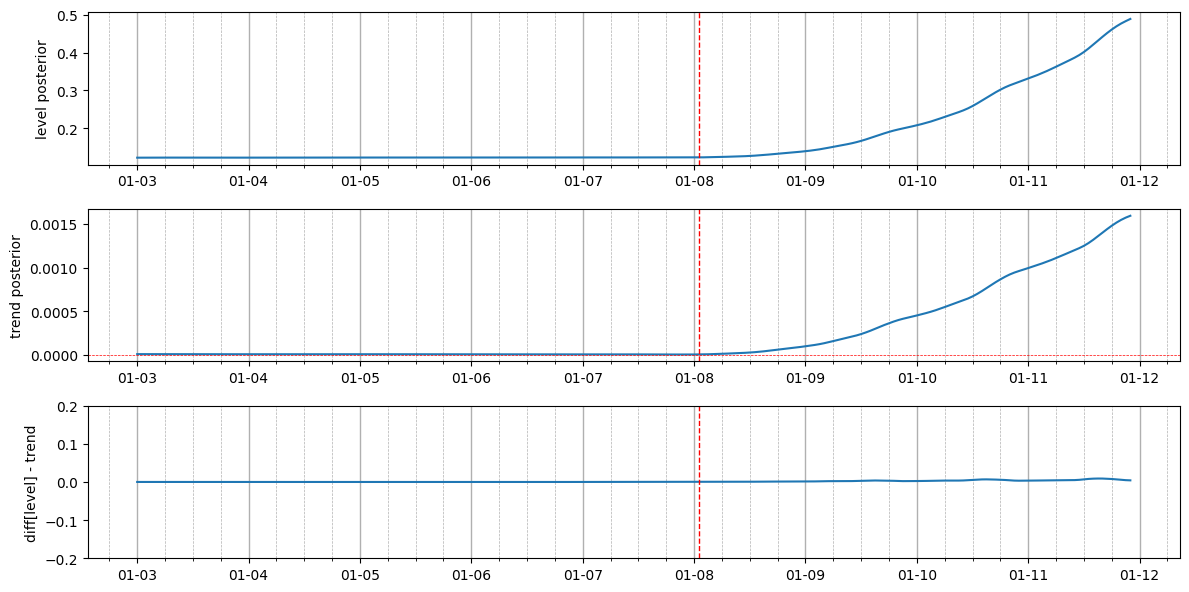

In [7]:
fig, ax = plt.subplots(3,1, figsize=(12,6))
ax[0].plot(time, level_pos)
ax[0].set_ylabel("level posterior")
ax[1].plot(time,trend)
ax[1].set_ylabel("trend posterior")
ax[1].axhline(0, color='red', linestyle="--", linewidth=0.5)
ax[2].plot(time, diff)
ax[2].set_ylim(-0.2, 0.2)
ax[2].set_ylabel("diff[level] - trend")

# Set global x-range for all axes
for a in ax:
    a.xaxis.set_major_locator(DayLocator(interval=1))
    a.xaxis.set_minor_locator(HourLocator(byhour=[0, 6, 12, 18]))
    a.xaxis.set_major_formatter(DateFormatter("%m-%d"))
    a.grid(which="major", axis="x", linestyle="-", linewidth=1)
    a.grid(which="minor", axis="x", linestyle="--", linewidth=0.5)
    a.axvline(time[time_anomaly+1], color="red", linestyle="--", linewidth=1)

fig.tight_layout()
plt.show()

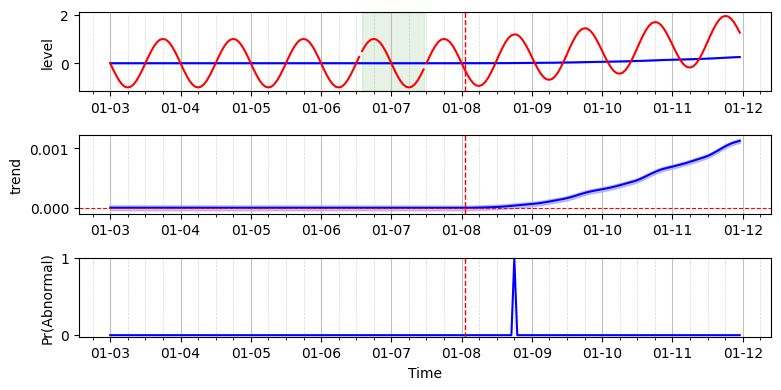

In [8]:
fig, ax = plot_skf_states(
    data_processor=data_processor,
    states=states,
    model_prob=prob,
    states_to_plot=["level", "trend"],
)
ax[0].axvline(time[time_anomaly+1], color="red", linestyle="--", linewidth=1)
ax[1].axvline(time[time_anomaly+1], color="red", linestyle="--", linewidth=1)
ax[2].axvline(time[time_anomaly+1], color="red", linestyle="--", linewidth=1)
fig.set_size_inches(8, 4)
fig.tight_layout()
plt.show()

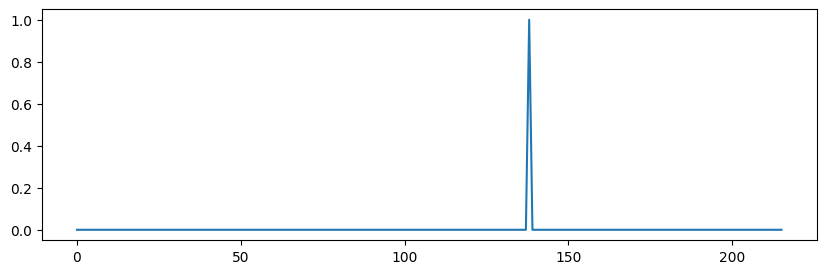

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10,3))
plt.plot(prob)